In [1]:
# in order to install the required packages for the snn conversion, 
# you need the following packages
# furthemore you must have installed miniconda or anaconda
# and activated a virtual environment to execute the following commands

# %conda install akida
# %conda install cnn2snn
# %conda install akida-models

In [2]:
# yolo
# imagenet
# cnn
# wider

model_name = "cnn"

In [3]:
import tensorflow as tf
import utils

2023-03-24 08:44:16.885320: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 08:44:16.994081: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-24 08:44:17.023264: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-24 08:44:17.537606: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [4]:
ds_train, ds_train_info = utils.getDataset('train', only_one=True)
ds_test, ds_test_info = utils.getDataset('test', only_one=True)
ds_eval, ds_eval_info = utils.getDataset('validation', only_one=True)

2023-03-24 08:44:18.883162: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 08:44:20.158630: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22826 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:e6:00.0, compute capability: 7.5
2023-03-24 08:44:20.159519: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9618 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:d5:00.0, compute capability: 7.5


2023-03-24 08:44:22.520197: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


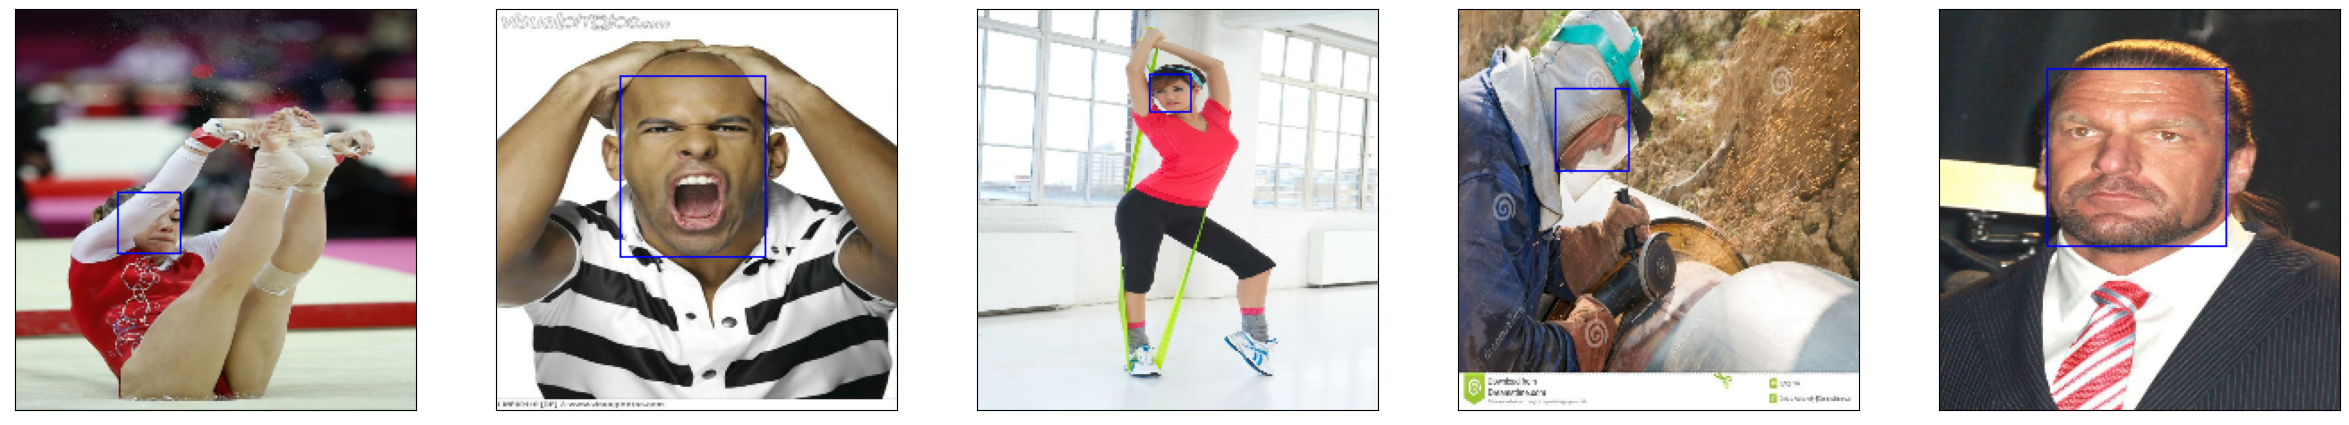

In [5]:
for ele in ds_train.take(1):
      utils.display_imgs(tf.image.draw_bounding_boxes(
      ele[0], ele[1], [(0, 0, 1, 1) for _ in range(100)], name=None), "train")

In [6]:
from tensorflow.keras.models import load_model
from akida_models import yolo_base, yolo_widerface_pretrained
from tensorflow.keras.utils import get_file
from tensorflow.keras.layers import Dense, Flatten, Conv2D, ReLU, BatchNormalization
from tensorflow.keras import Sequential

In [7]:
model : Sequential = Sequential()

if(model_name == "yolo"):
    yolo_model = yolo_base()
    
    print(yolo_model.summary())
    
    model.add(yolo_model)
    
elif model_name == "wider":
    
    model, anchors = yolo_widerface_pretrained()
    
    print(model.predict(ds_eval))
    
    #utils.predict(model=model, model_name=model_name, ds)
    
elif(model_name == "imagenet"):
    
    model_file = get_file(
        "akidanet_imagenet_224_alpha_50.h5",
        "http://data.brainchip.com/models/akidanet/akidanet_imagenet_224_alpha_50.h5",
        cache_subdir='models/akidanet_imagenet')
    model.add(load_model(model_file))

elif(model_name == "cnn"):
    
    input_shapes = [
    (224,224,3),
    (224,224,16),
    (112,112,32),
    (56,56,64),
    (28,28,128),
    (14,14,1024),
    (14,14,512),
    (7,7,256),
    (7,7,128),
    (7,7,64),
    (7,7,32),
    (4,)]

    for input_shape in input_shapes:
    
        model.add(Conv2D(2,7, input_shape=input_shape)) 
        model.add(BatchNormalization(input_shape=input_shape)) 
        model.add(ReLU(input_shape=input_shape))

model.add(Flatten())
model.add(Dense(4, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 218, 2)       296       
                                                                 
 batch_normalization (BatchN  (None, 218, 218, 2)      8         
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 218, 218, 2)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 212, 212, 2)       198       
                                                                 
 batch_normalization_1 (Batc  (None, 212, 212, 2)      8         
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 212, 212, 2)       0

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"), 
              metrics=['accuracy'])#[tf.keras.metrics.MeanIoU(num_classes=1)])


callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)]

In [15]:
dir(ds_train)

['_GeneratorState',
 '__abstractmethods__',
 '__annotations__',
 '__bool__',
 '__class__',
 '__class_getitem__',
 '__debug_string__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__tf_tracing_type__',
 '__weakref__',
 '_abc_impl',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_apply_debug_options',
 '_as_serialized_graph',
 '_buffer_size',
 '_checkpoint_dependencies',
 '_common_args',
 '_consumers',
 '_convert_variables_to_tensors',
 '_deferred_dependencies',
 '_deserialization_dependencies',
 '_deserialize_from_proto',
 '_export_to_saved_model_graph',
 '_flat_shapes',
 '_flat_structure',
 '_flat_types',
 '_functions',
 '_

In [9]:
model.fit(
    x=ds_train,
    epochs=40,
    validation_data=ds_eval,
    callbacks=callbacks
)

Epoch 1/40


2023-03-24 08:44:34.025792: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


37/37 [==============================] - 16s 290ms/step - loss: 0.1669 - accuracy: 0.7480 - val_loss: 0.1694 - val_accuracy: 0.7594
Epoch 2/40
37/37 [==============================] - 7s 196ms/step - loss: 0.1698 - accuracy: 0.7612 - val_loss: 0.1694 - val_accuracy: 0.7594
Epoch 3/40
37/37 [==============================] - 7s 194ms/step - loss: 0.1698 - accuracy: 0.7612 - val_loss: 0.1694 - val_accuracy: 0.7594
Epoch 4/40
37/37 [==============================] - 7s 196ms/step - loss: 0.1698 - accuracy: 0.7612 - val_loss: 0.1694 - val_accuracy: 0.7594
Epoch 5/40
37/37 [==============================] - 7s 196ms/step - loss: 0.1698 - accuracy: 0.7612 - val_loss: 0.1694 - val_accuracy: 0.7594
Epoch 6/40
37/37 [==============================] - 7s 195ms/step - loss: 0.1698 - accuracy: 0.7612 - val_loss: 0.1694 - val_accuracy: 0.7594


In [10]:
results = model.evaluate(
  ds_eval
)

print("test loss, test acc:", results)

if(model_name == "imagenet"):
  model.save("models/imagenet_model")
elif(model_name == "yolo"):
  model.save("models/yolo_model")
elif(model_name == "cnn"):
  model.save("models/cnn_model")

9/9 [==============================] - 0s 43ms/step - loss: 0.1694 - accuracy: 0.7594
test loss, test acc: [0.16935789585113525, 0.759358286857605]


INFO:tensorflow:Assets written to: models/cnn_model/assets


INFO:tensorflow:Assets written to: models/cnn_model/assets


In [11]:
if(model_name == "imagenet"):
  model = tf.keras.models.load_model("models/imagenet_model")
elif(model_name == "yolo"):
  model = tf.keras.models.load_model("models/yolo_model")
elif(model_name == "cnn"):
  model = tf.keras.models.load_model("models/cnn_model")

4/4 [==============================] - 1s 13ms/step


Groundtruth: [[[0.31366906 0.296875   0.60431653 0.4296875 ]]

 [[0.167576   0.39648438 0.40530008 0.6044922 ]]

 [[0.4589443  0.19140625 0.51466274 0.22167969]]

 [[0.45947757 0.25683594 0.6135298  0.41601562]]

 [[0.16797154 0.31347656 0.6192171  0.67578125]]

 [[0.46304542 0.73046875 0.6153161  0.87402344]]

 [[0.2835596  0.41992188 0.4494721  0.58984375]]

 [[0.22460938 0.36621094 0.40625    0.5625    ]]

 [[0.1374269  0.51171875 0.41520467 0.63671875]]

 [[0.14578006 0.5625     0.49872124 0.8203125 ]]

 [[0.08220211 0.22949219 0.38235295 0.5126953 ]]

 [[0.3349131  0.5410156  0.51184833 0.7324219 ]]

 [[0.44319776 0.48632812 0.49789622 0.5175781 ]]

 [[0.2826087  0.45898438 0.5124224  0.5839844 ]]

 [[0.12699565 0.46484375 0.27140784 0.5859375 ]]

 [[0.13541667 0.3984375  0.26302084 0.46289062]]

 [[0.07511737 0.36132812 0.3943662  0.5253906 ]]

 [[0.27525622 0.4375     0.39824304 0.49804688]]

 [[0.11728395 0.4248047  0.263374

2023-03-24 08:45:31.092229: W tensorflow/core/kernels/image/draw_bounding_box_op.cc:150] Bounding box (214,274,248,306) is completely outside the image and will not be drawn.
2023-03-24 08:45:31.092270: W tensorflow/core/kernels/image/draw_bounding_box_op.cc:150] Bounding box (142,225,204,253) is completely outside the image and will not be drawn.
2023-03-24 08:45:31.092276: W tensorflow/core/kernels/image/draw_bounding_box_op.cc:150] Bounding box (144,236,222,294) is completely outside the image and will not be drawn.
2023-03-24 08:45:31.092283: W tensorflow/core/kernels/image/draw_bounding_box_op.cc:150] Bounding box (186,232,225,274) is completely outside the image and will not be drawn.
2023-03-24 08:45:31.092294: W tensorflow/core/kernels/image/draw_bounding_box_op.cc:150] Bounding box (136,233,185,258) is completely outside the image and will not be drawn.
2023-03-24 08:45:31.092303: W tensorflow/core/kernels/image/draw_bounding_box_op.cc:150] Bounding box (135,244,146,251) is co

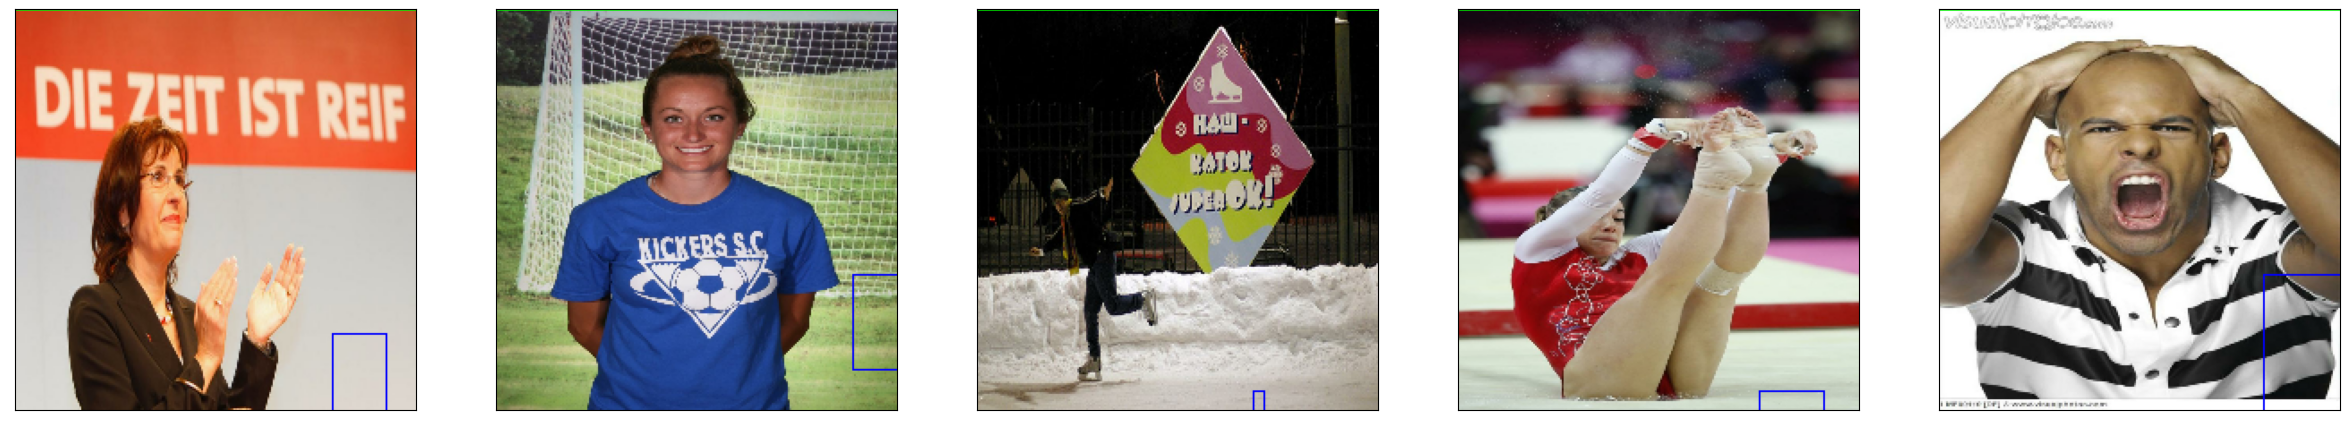

In [12]:
utils.predict(model=model, model_name=model_name, ds=ds_train)

4/4 [==============================] - 0s 14ms/step


Groundtruth: [[[0.04116638 0.33691406 0.14236706 0.45996094]]

 [[0.14641288 0.6699219  0.25475842 0.72265625]]

 [[0.39908853 0.43359375 0.6295573  0.71191406]]

 [[0.5933852  0.47265625 0.63878083 0.5644531 ]]

 [[0.2474026  0.140625   0.6707792  0.6542969 ]]

 [[0.5625     0.46289062 0.6640625  0.59375   ]]

 [[0.24390244 0.09960938 0.33231708 0.18945312]]

 [[0.13689604 0.4091797  0.22474378 0.49804688]]

 [[0.21081577 0.38867188 0.42163154 0.57128906]]

 [[0.19722651 0.38085938 0.59938365 0.72753906]]

 [[0.3195435  0.49609375 0.48787448 0.58984375]]

 [[0.01041667 0.20898438 0.07552084 0.26757812]]

 [[0.36197916 0.43554688 0.6171875  0.5878906 ]]

 [[0.325      0.4658203  0.4390625  0.51171875]]

 [[0.12298682 0.61328125 0.48901904 0.82421875]]

 [[0.6502636  0.19921875 0.7012302  0.21875   ]]

 [[0.27818447 0.5078125  0.4275256  0.578125  ]]

 [[0.49323308 0.38671875 0.5593985  0.44921875]]

 [[0.19503546 0.20410156 0.675531

2023-03-24 08:45:32.734959: W tensorflow/core/kernels/image/draw_bounding_box_op.cc:150] Bounding box (144,260,168,272) is completely outside the image and will not be drawn.
2023-03-24 08:45:32.734994: W tensorflow/core/kernels/image/draw_bounding_box_op.cc:150] Bounding box (243,216,253,237) is completely outside the image and will not be drawn.
2023-03-24 08:45:32.735000: W tensorflow/core/kernels/image/draw_bounding_box_op.cc:150] Bounding box (236,214,259,243) is completely outside the image and will not be drawn.
2023-03-24 08:45:32.735028: W tensorflow/core/kernels/image/draw_bounding_box_op.cc:150] Bounding box (138,248,220,295) is completely outside the image and will not be drawn.
2023-03-24 08:45:32.735032: W tensorflow/core/kernels/image/draw_bounding_box_op.cc:150] Bounding box (256,155,267,160) is completely outside the image and will not be drawn.
2023-03-24 08:45:32.735035: W tensorflow/core/kernels/image/draw_bounding_box_op.cc:150] Bounding box (173,224,206,240) is co

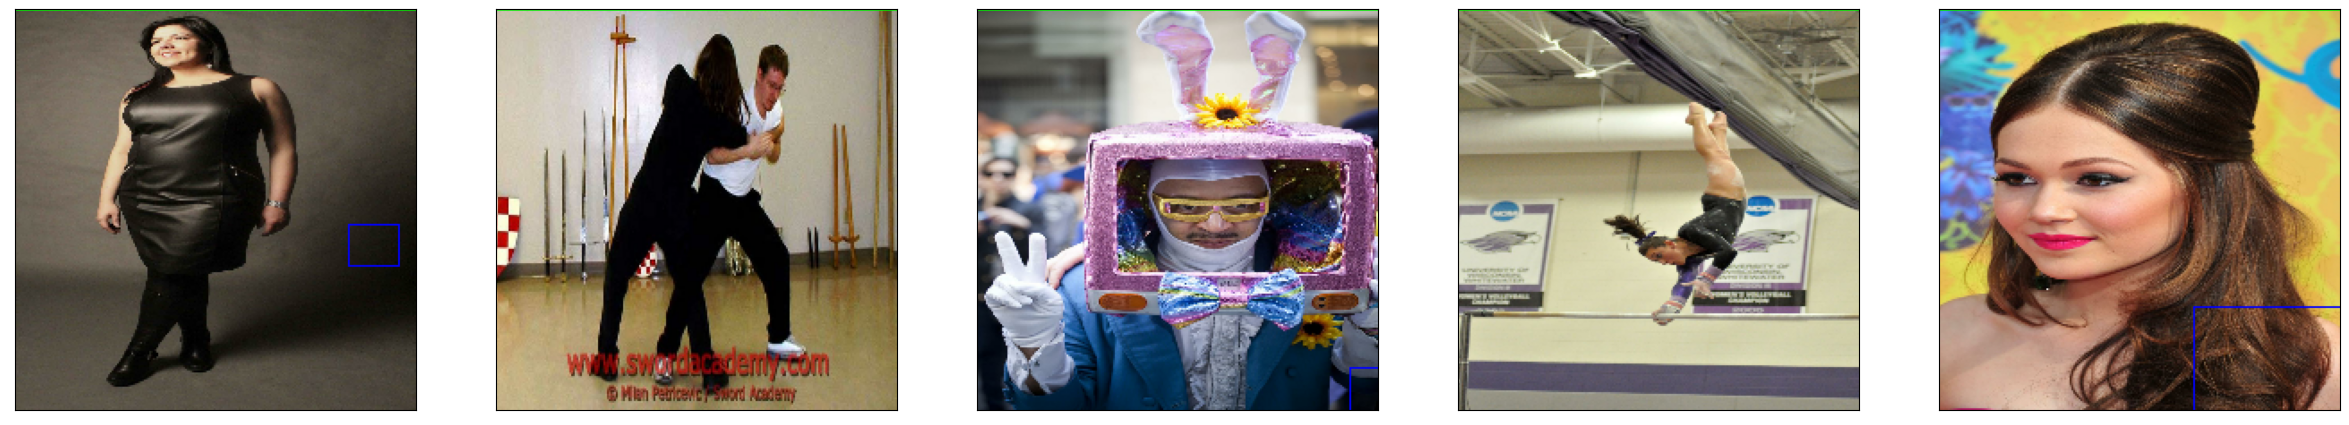

In [13]:
utils.predict(model=model, model_name=model_name, ds=ds_eval)